In [3]:
# Step 1: Environment Setup & Library Installation
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# -q (quiet) to keep the notebook clean
!pip install -q h2o tpot shap lime

print("Libraries installed and imported successfully.")

# Step 2: Define Paths & Load Tabular Data
BASE_DIR = '/kaggle/input/petfinder-project'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

def load_dataset(base_path):
    """
    Loads the core datasets and label mapping files from the Kaggle input directory.
    Returns a dictionary containing all dataframes.
    """
    print(f"Loading data from: {base_path}")
    
    try:
        
        train = pd.read_csv(os.path.join(TRAIN_DIR, 'train.csv'))
        test = pd.read_csv(os.path.join(TEST_DIR, 'test.csv'))
        
        breed_labels = pd.read_csv(os.path.join(base_path, 'breed_labels.csv'))
        color_labels = pd.read_csv(os.path.join(base_path, 'color_labels.csv'))
        state_labels = pd.read_csv(os.path.join(base_path, 'state_labels.csv'))
        
        print(f"   Shape of Training Data: {train.shape}")
        print(f"   Shape of Test Data:     {test.shape}")
        print("Data loaded successfully.")
        
        return {
            'train': train,
            'test': test,
            'breed_labels': breed_labels,
            'color_labels': color_labels,
            'state_labels': state_labels
        }
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file. Make sure the dataset is added. \n{e}")
        return None

data_bundle = load_dataset(BASE_DIR)

if data_bundle:
    train_df = data_bundle['train']
    test_df = data_bundle['test']
    breed_labels = data_bundle['breed_labels']
    color_labels = data_bundle['color_labels']
    state_labels = data_bundle['state_labels']

    print("\n--- First 3 Rows of Training Data ---")
    display(train_df.head(3))

Libraries installed and imported successfully.
Loading data from: /kaggle/input/petfinder-project
   Shape of Training Data: (14993, 24)
   Shape of Test Data:     (3972, 23)
Data loaded successfully.

--- First 3 Rows of Training Data ---


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3


In [4]:
# Step 2: Data Integration & Cleaning
def process_dataframe(df, breed_lbl, color_lbl, state_lbl):
    """
    1. Merges label dataframes to replace IDs with readable names.
    2. Handles missing values (Imputation).
    3. Creates basic derived features (HasName).
    """
    df_clean = df.copy()
    
    # --- A. MERGING LABELS ---
    breed_lbl_clean = breed_lbl.drop(['Type'], axis=1)
    
    df_clean = df_clean.merge(breed_lbl_clean, left_on='Breed1', right_on='BreedID', how='left')
    df_clean = df_clean.rename(columns={'BreedName': 'Breed1_Name'})
    df_clean = df_clean.drop(['BreedID'], axis=1) # Drop redundant ID
    
    df_clean = df_clean.merge(breed_lbl_clean, left_on='Breed2', right_on='BreedID', how='left', suffixes=('', '_2'))
    df_clean = df_clean.rename(columns={'BreedName': 'Breed2_Name'})
    df_clean = df_clean.drop(['BreedID'], axis=1)
    
    for i in [1, 2, 3]:
        col_name = f'Color{i}'
        df_clean = df_clean.merge(color_lbl, left_on=col_name, right_on='ColorID', how='left')
        df_clean = df_clean.rename(columns={'ColorName': f'{col_name}_Name'})
        df_clean = df_clean.drop(['ColorID'], axis=1)
        
    df_clean = df_clean.merge(state_lbl, left_on='State', right_on='StateID', how='left')
    df_clean = df_clean.rename(columns={'StateName': 'State_Name'})
    df_clean = df_clean.drop(['StateID'], axis=1)
    
    
    df_clean['HasName'] = df_clean['Name'].apply(lambda x: 0 if pd.isna(x) else 1)
    df_clean['Name'] = df_clean['Name'].fillna('No Name')
    
    # 2. Description Strategy
    df_clean['Description'] = df_clean['Description'].fillna('No description')
    
    # 3. Fill NaN in categorical names
    cat_cols = ['Breed1_Name', 'Breed2_Name', 'Color1_Name', 
                'Color2_Name', 'Color3_Name', 'State_Name']
    
    for col in cat_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('None')

    return df_clean

print("Processing Training Data...")
train_df_clean = process_dataframe(train_df, breed_labels, color_labels, state_labels)

print("Processing Test Data...")
test_df_clean = process_dataframe(test_df, breed_labels, color_labels, state_labels)

# --- Sanity Check ---
print("\n--- Cleaning Report ---")
missing_train = train_df_clean[['Name', 'Description', 'HasName']].isnull().sum().sum()
print(f"Remaining Missing Values in Key Columns (Train): {missing_train}")
print(f"New Shape (Train): {train_df_clean.shape}")

if 'Type_x' in train_df_clean.columns or 'Type_y' in train_df_clean.columns:
    print("Warning: Duplicate 'Type' columns detected. Check merge logic.")
else:
    print("Schema Check: Columns are clean (No duplicate Type_x/y).")

display(train_df_clean[['Name', 'HasName', 'Breed1_Name', 'Color1_Name']].head(3))

Processing Training Data...
Processing Test Data...

--- Cleaning Report ---
Remaining Missing Values in Key Columns (Train): 0
New Shape (Train): (14993, 31)
Schema Check: Columns are clean (No duplicate Type_x/y).


,Name,HasName,Breed1_Name,Color1_Name
0,Nibble,1,Tabby,Black
1,No Name Yet,1,Domestic Medium Hair,Black
2,Brisco,1,Mixed Breed,Brown


In [5]:
# Step 3: Text Feature Engineering (FastText Implementation)
import re
import fasttext
import numpy as np
from tqdm.notebook import tqdm

!pip install -q fasttext

def clean_text(text):
    """
    Standardizes text: lowercase, removes special chars, handles extra spaces.
    """
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return " ".join(text.split())

def train_and_extract_fasttext(df_train, df_test, embedding_dim=100):
    """
    Trains a FastText model on the corpus and generates sentence embeddings.
    Replaces TF-IDF as per advanced project requirements.
    """
    print(f"Preprocessing text for FastText (Dim: {embedding_dim})...")
    
    # 1. Prepare Corpus for Training
    all_descriptions = pd.concat([df_train['Description'], df_test['Description']])
    cleaned_corpus = all_descriptions.apply(clean_text)
    
    with open('pet_descriptions.txt', 'w', encoding='utf-8') as f:
        for line in cleaned_corpus:
            f.write(line + '\n')
            
    # 2. Train FastText Model (Unsupervised - Skipgram)
    print("Training FastText model on dataset corpus...")
    model = fasttext.train_unsupervised('pet_descriptions.txt', model='skipgram', dim=embedding_dim)
    
    # 3. Generate Embeddings (Vectorization)
    def get_sentence_vector(text):
        clean = clean_text(text)
        if not clean:
            return np.zeros(embedding_dim)
        return model.get_sentence_vector(clean)

    print("Extracting vectors...")
    cols = [f'ft_{i}' for i in range(embedding_dim)]
    
    train_vecs = np.array([get_sentence_vector(x) for x in df_train['Description']])
    train_df_vec = pd.DataFrame(train_vecs, columns=cols)
    
    test_vecs = np.array([get_sentence_vector(x) for x in df_test['Description']])
    test_df_vec = pd.DataFrame(test_vecs, columns=cols)
    
    # 4. Basic Stats (Length/Word Count)
    for df in [df_train, df_test]:
        df['Desc_Len'] = df['Description'].apply(lambda x: len(str(x)))
        df['Word_Count'] = df['Description'].apply(lambda x: len(str(x).split()))
    
    # Merge Features
    train_final = pd.concat([df_train.reset_index(drop=True), train_df_vec], axis=1)
    test_final = pd.concat([df_test.reset_index(drop=True), test_df_vec], axis=1)
    
    print(f"✅ FastText processing complete. Added {embedding_dim} embedding features.")
    return train_final, test_final, cols

train_df_text, test_df_text, text_feat_cols = train_and_extract_fasttext(train_df_clean, test_df_clean)

print(f"\nTraining Data Shape: {train_df_text.shape}")
display(train_df_text[['Description'] + text_feat_cols[:4]].head(3))

🔹 Preprocessing text for FastText (Dim: 100)...
🔹 Training FastText model on dataset corpus...


Read 1M words
Number of words:  7461
Number of labels: 0
Progress: 100.0% words/sec/thread:   58444 lr:  0.000000 avg.loss:  2.220239 ETA:   0h 0m 0s 33.4% words/sec/thread:   57691 lr:  0.033289 avg.loss:  2.313764 ETA:   0h 0m22s  0h 0m 0s


🔹 Extracting vectors...
✅ FastText processing complete. Added 100 embedding features.

Training Data Shape: (14993, 133)


,Description,ft_0,ft_1,ft_2,ft_3
0,Nibble is a 3+ month old ball of cuteness. He ...,0.039047,-0.087027,-0.018830,-0.013129
1,I just found it alone yesterday near my apartm...,0.054764,-0.096452,-0.055462,0.016949
2,Their pregnant mother was dumped by her irresp...,0.063269,-0.076354,-0.007935,-0.009496


In [6]:
# Step 4: Image Feature Extraction (EfficientNetB0 - NO PCA - GPU Optimized)
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image as k_image
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

print("TensorFlow GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

def extract_image_features_no_pca(df_train, df_test, img_dir):
    """
    1. Loads EfficientNetB0.
    2. Extracts ALL 1280 raw features (No PCA loss).
    """
    print(f"Initializing EfficientNetB0 (Full Features)...")
    
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    
    def process_images(df, folder_name):
        features_list = []
        print(f"   Processing {len(df)} images from {folder_name}...")
        
        full_img_dir = os.path.join(BASE_DIR, folder_name)
        
        for idx, pet_id in tqdm(enumerate(df['PetID']), total=len(df)):
            img_path = os.path.join(full_img_dir, f"{pet_id}-1.jpg")
            
            if os.path.exists(img_path):
                try:
                    # Resize to 224x224
                    img = k_image.load_img(img_path, target_size=(224, 224))
                    x = k_image.img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    x = preprocess_input(x)
                    
                    feat = model.predict(x, verbose=0)
                    features_list.append(feat[0])
                except Exception:
                    features_list.append(np.zeros(1280))
            else:
                features_list.append(np.zeros(1280))
                
        return np.array(features_list)

    print("   Extracting Train Images...")
    train_feats = process_images(df_train, 'train_images')
    
    print("   Extracting Test Images...")
    test_feats = process_images(df_test, 'test_images')
    
    # Create DataFrames (1280 columns)
    cols = [f'img_raw_{i}' for i in range(1280)]
    train_feat_df = pd.DataFrame(train_feats, columns=cols)
    test_feat_df = pd.DataFrame(test_feats, columns=cols)
    
    train_final = pd.concat([df_train.reset_index(drop=True), train_feat_df], axis=1)
    test_final = pd.concat([df_test.reset_index(drop=True), test_feat_df], axis=1)
    
    print(f"✅ Image processing complete. Added {1280} RAW features (No PCA).")
    return train_final, test_final, cols

train_df_full, test_df_full, img_feat_cols = extract_image_features_no_pca(
    train_df_text, 
    test_df_text, 
    BASE_DIR
)

2025-12-26 07:48:29.328889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766735309.822366      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766735309.944129      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766735311.172232      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766735311.172260      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766735311.172263      55 computation_placer.cc:177] computation placer alr

TensorFlow GPU Available: True
Initializing EfficientNetB0 (Full Features)...


I0000 00:00:1766735328.443263      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766735328.447266      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
   Extracting Train Images...
   Processing 14993 images from train_images...


  0%|          | 0/14993 [00:00<?, ?it/s]

I0000 00:00:1766735334.140643     162 service.cc:152] XLA service 0x7c4b88004280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766735334.140681     162 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766735334.140685     162 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766735335.129430     162 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-26 07:49:01.580559: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 07:49:01.715107: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 07:49:02.404715: E external/local_xl

   Extracting Test Images...
   Processing 3972 images from test_images...


  0%|          | 0/3972 [00:00<?, ?it/s]

✅ Image processing complete. Added 1280 RAW features (No PCA).


In [7]:
# Step 4.1: Hand-Crafted Image Features (Brightness, Saturation, Texture)
import cv2
import numpy as np
from PIL import Image
import os
from tqdm.notebook import tqdm

def extract_handcrafted_features(df, folder_name):
    """
    Extracts explicit visual features:
    1. Brightness (Is the photo dark?)
    2. Saturation (Is the photo colorful/vibrant?)
    3. Edge Density (Is the pet fluffy/textured?)
    """
    print(f"Extracting Hand-crafted features from {folder_name}...")
    
    full_img_dir = os.path.join(BASE_DIR, folder_name)
    
    brightness_vals = []
    saturation_vals = []
    edge_vals = []
    
    for pet_id in tqdm(df['PetID'], total=len(df)):
        img_path = os.path.join(full_img_dir, f"{pet_id}-1.jpg")
        
        if os.path.exists(img_path):
            try:
                # Read with OpenCV
                img = cv2.imread(img_path)
                
                if img is not None:
                    # 1. Brightness & Saturation (HSV Space)
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    
                    sat = np.mean(hsv[:, :, 1])
                    bright = np.mean(hsv[:, :, 2])
                    
                    # 2. Texture/Edge Density (Canny)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    edges = cv2.Canny(gray, 100, 200)
                   
                    edge_density = np.sum(edges) / (edges.size * 255)
                    
                    brightness_vals.append(bright)
                    saturation_vals.append(sat)
                    edge_vals.append(edge_density)
                else:
                    brightness_vals.append(0)
                    saturation_vals.append(0)
                    edge_vals.append(0)
            except:
                brightness_vals.append(0)
                saturation_vals.append(0)
                edge_vals.append(0)
        else:
            brightness_vals.append(0)
            saturation_vals.append(0)
            edge_vals.append(0)
            
    temp_df = pd.DataFrame({
        'meta_Brightness': brightness_vals,
        'meta_Saturation': saturation_vals,
        'meta_EdgeDensity': edge_vals
    })
    
    return temp_df

# 1. Extract for Train
extra_feats_train = extract_handcrafted_features(train_df_full, 'train_images')
train_df_full = pd.concat([train_df_full, extra_feats_train], axis=1)

# 2. Extract for Test
extra_feats_test = extract_handcrafted_features(test_df_full, 'test_images')
test_df_full = pd.concat([test_df_full, extra_feats_test], axis=1)

print(f"✅ Added Hand-crafted features. New Train Shape: {train_df_full.shape}")
display(train_df_full[['PetID', 'meta_Brightness', 'meta_Saturation']].head(3))

Extracting Hand-crafted features from train_images...


  0%|          | 0/14993 [00:00<?, ?it/s]

Extracting Hand-crafted features from test_images...


  0%|          | 0/3972 [00:00<?, ?it/s]

✅ Added Hand-crafted features. New Train Shape: (14993, 1416)


,PetID,meta_Brightness,meta_Saturation
0,86e1089a3,100.373779,41.877441
1,6296e909a,101.640137,97.680176
2,3422e4906,176.071289,18.599121


In [12]:
# Step 4.2: Data Transformation & Preparation (Pre-Modeling)
from sklearn.preprocessing import LabelEncoder

def prepare_data_for_modeling(df):
    """
    1. Encodes categorical columns (String -> Number).
    2. Drops ID columns and raw text.
    3. Performs Sanity Check.
    """
    print("Preparing data for modeling...")
    df_mod = df.copy()
    
    # 1. Identify Categorical Columns (Object type)
    cat_cols = ['Type', 'Gender', 'Color1_Name', 'Color2_Name', 'Color3_Name', 
                'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                'Sterilized', 'Health', 'State_Name', 'Breed1_Name', 'Breed2_Name']
    
    # Encode Categorical Features
    le = LabelEncoder()
    for col in cat_cols:
        if col in df_mod.columns:
            
            df_mod[col] = le.fit_transform(df_mod[col].astype(str))
            
    # 2. Drop Non-Feature Columns
    drop_cols = ['Name', 'Description', 'RescuerID', 'PetID']
    
    existing_drop = [c for c in drop_cols if c in df_mod.columns]
    df_mod = df_mod.drop(columns=existing_drop, axis=1)
    
    return df_mod

def sanity_check(df, name="Dataset"):
    print(f"\n---Sanity Check for {name} ---")
    
    # Check for NaN
    missing = df.isnull().sum().sum()
    if missing == 0:
        print("✅ Missing Values: None (Perfect)")
    else:
        print(f"CRITICAL: Found {missing} missing values!")
        print(df.columns[df.isnull().any()].tolist())
        
    # Check for Object columns (Text that wasn't encoded)
    non_numeric = df.select_dtypes(include=['object']).columns.tolist()
    if len(non_numeric) == 0:
        print("✅ Data Types: All Numeric (Ready for XGBoost)")
    else:
        print(f"CRITICAL: Found non-numeric columns: {non_numeric}")
        
    print(f"✅ Final Shape: {df.shape}")

print("Processing Training Data...")
train_ready = prepare_data_for_modeling(train_df_full)
sanity_check(train_ready, "Training Data")

print("\nProcessing Test Data...")
test_ready = prepare_data_for_modeling(test_df_full)
sanity_check(test_ready, "Test Data")

Processing Training Data...
Preparing data for modeling...

---Sanity Check for Training Data ---
✅ Missing Values: None (Perfect)
✅ Data Types: All Numeric (Ready for XGBoost)
✅ Final Shape: (14993, 1412)

Processing Test Data...
Preparing data for modeling...

---Sanity Check for Test Data ---
✅ Missing Values: None (Perfect)
✅ Data Types: All Numeric (Ready for XGBoost)
✅ Final Shape: (3972, 1411)


In [ ]:
# Step 4.6:Baseline Classifiers (+ PCA)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.pipeline import Pipeline
import time
import pandas as pd
import numpy as np

# Import Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def run_baselines_fast_split(df_clean, target_col='AdoptionSpeed'):
    print("Baseline Models (Hold-out Validation with PCA)...")
    
    # 1. Prepare X and y
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    
    # 2. Simple Train/Validation Split (20% for Validation)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"   Data Split: Train={X_train.shape}, Val={X_val.shape}")
    
    # 3. Define Models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        "SVM": SVC(kernel='rbf', random_state=42), 
        "MLP": MLPClassifier(max_iter=300, random_state=42),
        "XGBoost (GPU)": XGBClassifier(
            n_estimators=200, 
            learning_rate=0.05, 
            random_state=42,
            tree_method='hist',
            device='cuda'
        )
    }
    
    results = []
    
    # 4. Training Loop
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        
        # Build Pipeline
        steps = [('scaler', StandardScaler())]
        
        # Apply PCA only for CPU-heavy models to speed them up
        if name not in ["XGBoost (GPU)", "Decision Tree", "Random Forest"]:
            steps.append(('pca', PCA(n_components=0.95, random_state=42))) 
            
        steps.append(('classifier', model))
        pipeline = Pipeline(steps)
        
        try:
            
            pipeline.fit(X_train, y_train)
            
            y_pred = pipeline.predict(X_val)
            
            score = cohen_kappa_score(y_val, y_pred, weights='quadratic')
            elapsed = time.time() - start_time
            
            results.append({
                'Model': name,
                'QWK Score': score,
                'Time (s)': elapsed
            })
            print(f"      ✅ Score: {score:.4f} | Time: {elapsed:.1f}s")
            
        except Exception as e:
            print(f"Failed: {e}")

    results_df = pd.DataFrame(results).sort_values(by='QWK Score', ascending=False)
    print("\nBaseline Results (Fast Split):")
    display(results_df.style.background_gradient(cmap='viridis', subset=['QWK Score']))
    
    return results_df

baseline_results = run_baselines_fast_split(train_ready)

Baseline Models (Hold-out Validation with PCA)...
   Data Split: Train=(11994, 1411), Val=(2999, 1411)
Training Logistic Regression...
      ✅ Score: 0.2040 | Time: 24.7s
Training KNN...
      ✅ Score: 0.0971 | Time: 4.5s
Training Decision Tree...
      ✅ Score: 0.1375 | Time: 36.4s
Training Random Forest...
      ✅ Score: 0.1877 | Time: 12.6s
Training SVM...
      ✅ Score: 0.2198 | Time: 132.5s
Training MLP...
      ✅ Score: 0.1640 | Time: 37.0s
Training XGBoost (GPU)...
      ✅ Score: 0.3282 | Time: 36.1s

Baseline Results (Fast Split):


,Model,QWK Score,Time (s)
6,XGBoost (GPU),0.328175,36.105251
4,SVM,0.219789,132.482316
0,Logistic Regression,0.203952,24.716324
3,Random Forest,0.187682,12.649237
5,MLP,0.164008,36.997036
2,Decision Tree,0.137457,36.361419
1,KNN,0.097120,4.486200


### Ensemble Methods (Hybrid Strategy)

Based on the baseline results, **XGBoost** significantly outperformed other models due to its ability to handle high-dimensional data (1,400+ features) efficiently on the GPU. However, models like **SVM** and **Logistic Regression** struggle with such high dimensionality in terms of training time and performance.

To build a robust ensemble without exceeding Kaggle's computational limits, we implemented a **Hybrid Strategy**:
1.  **XGBoost:** Trained on **Full Raw Features** (utilizing GPU acceleration) to maximize accuracy.
2.  **SVM & Logistic Regression:** Trained on **PCA-Reduced Features (50 components)**. This drastically reduces training time while maintaining essential variance, allowing these models to contribute diverse perspectives to the ensemble.

In [ ]:
# Step 4.7: Ensemble Methods (Hybrid Strategy: Raw for XGB, PCA for Others)
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import numpy as np

def run_final_ensemble(df_clean, target_col='AdoptionSpeed'):
    print("Starting Final Ensemble (Hybrid Strategy)...")
    
    # 1. Prepare Data
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    
    # Split (80/20) - Stratified
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print(f"   Data Shape: {X_train.shape} features")
    
    # 2. Define Estimators with Specific Preprocessing
    # MODEL 1: XGBoost # Uses ALL features (Raw Image Features)
    xgb_clf = XGBClassifier(
        n_estimators=500,       
        learning_rate=0.02,     
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        device='cuda',          
        eval_metric='mlogloss'
    )
    
    # MODEL 2: SVM # Uses PCA reduced features 
    svm_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)), 
        ('clf', SVC(kernel='rbf', probability=True, C=1.0, random_state=42))
    ])
    
    # MODEL 3: Logistic Regression # Uses PCA reduced features
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, C=0.5, random_state=42))
    ])
    
    # List of estimators for Ensemble
    estimators = [
        ('xgb', xgb_clf),
        ('svm', svm_pipe),
        ('lr', lr_pipe)
    ]
    
    results = []
    
    # 3. Voting Classifier 
    print("Training Voting Classifier (Soft)...")
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    
    start = time.time()
    voting_clf.fit(X_train, y_train)
    y_pred_vote = voting_clf.predict(X_val)
    elapsed = time.time() - start
    
    score_vote = cohen_kappa_score(y_val, y_pred_vote, weights='quadratic')
    results.append({'Model': 'Voting Ensemble', 'QWK Score': score_vote, 'Time (s)': elapsed})
    print(f"      ✅ Score: {score_vote:.4f} | Time: {elapsed:.1f}s")
    
   # 4. Stacking Classifier 
    print("Training Stacking Classifier...")
   
    stacking_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(),
        cv=3,
        n_jobs=-1
    )
    
    start = time.time()
    stacking_clf.fit(X_train, y_train)
    y_pred_stack = stacking_clf.predict(X_val)
    elapsed = time.time() - start
    
    score_stack = cohen_kappa_score(y_val, y_pred_stack, weights='quadratic')
    results.append({'Model': 'Stacking Ensemble', 'QWK Score': score_stack, 'Time (s)': elapsed})
    print(f"      ✅ Score: {score_stack:.4f} | Time: {elapsed:.1f}s")
    
    results_df = pd.DataFrame(results).sort_values(by='QWK Score', ascending=False)
    print("\nFinal Ensemble Results:")
    display(results_df.style.background_gradient(cmap='viridis', subset=['QWK Score']))
    
    return results_df, voting_clf, stacking_clf

# --- Execute ---
ensemble_results, best_voting_model, best_stacking_model = run_final_ensemble(train_ready)

Starting Final Ensemble (Hybrid Strategy)...
   Data Shape: (11994, 1411) features
Training Voting Classifier (Soft)...
      ✅ Score: 0.2556 | Time: 166.5s
Training Stacking Classifier...


[16:19:54] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



      ✅ Score: 0.3500 | Time: 305.2s

Final Ensemble Results:


,Model,QWK Score,Time (s)
1,Stacking Ensemble,0.350025,305.182157
0,Voting Ensemble,0.255598,166.543629


In [17]:
# Step 4.8: Rigorous Evaluation (5-Fold CV on Stacking Model)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import time

def run_rigorous_evaluation(df_clean, target_col='AdoptionSpeed', n_splits=5):
    print(f"Starting Rigorous Evaluation ({n_splits}-Fold CV) on Final Stacking Model...")
    print("Status: Running 5-Fold Cross-Validation on Stacking Ensemble. Please wait...")
    
    # 1. Prepare Full X and y 
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    
    # 2. Re-Define the Best Pipeline (The Stacking Model)
    
    # XGBoost (GPU)
    xgb_clf = XGBClassifier(
        n_estimators=500, learning_rate=0.02, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        tree_method='hist', device='cuda', eval_metric='mlogloss'
    )
    
    # SVM (PCA)
    svm_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)), 
        ('clf', SVC(kernel='rbf', probability=True, C=1.0, random_state=42))
    ])
    
    # LR (PCA)
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, C=0.5, random_state=42))
    ])
    
    estimators = [('xgb', xgb_clf), ('svm', svm_pipe), ('lr', lr_pipe)]
    
    # Final Stacking Model
    final_model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(),
        cv=3, 
        n_jobs=-1
    )
    
    # 3. Setup QWK Scorer
    def qwk(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    qwk_scorer = make_scorer(qwk)
    
    # 4. Run K-Fold Cross-Validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    start_time = time.time()
    
    scores = cross_val_score(final_model, X, y, cv=cv, scoring=qwk_scorer, n_jobs=1)
    elapsed = time.time() - start_time
    
    # 5. Report Results
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"\n✅ Rigorous Evaluation Complete! (Time: {elapsed/60:.1f} min)")
    print(f"   Scores per Fold: {scores}")
    print(f"   Mean QWK: {mean_score:.4f} (+/- {std_score:.4f})")
    
    # Create a summary dataframe
    results_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'QWK Score': scores
    })
    results_df.loc['Mean'] = mean_score
    results_df.loc['Std'] = std_score
    
    return results_df, mean_score

# --- Execute ---

cv_results, final_mean_score = run_rigorous_evaluation(train_ready)

print("\n---Final Robust Performance Estimate ---")
display(cv_results)

Starting Rigorous Evaluation (5-Fold CV) on Final Stacking Model...
Status: Running 5-Fold Cross-Validation on Stacking Ensemble. Please wait...


[16:52:22] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[17:07:36] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




✅ Rigorous Evaluation Complete! (Time: 25.4 min)
   Scores per Fold: [0.35594667 0.37327185 0.36113449 0.34966314 0.38431902]
   Mean QWK: 0.3649 (+/- 0.0124)

---Final Robust Performance Estimate ---


,Fold,QWK Score
0,1.000000,0.355947
1,2.000000,0.373272
2,3.000000,0.361134
3,4.000000,0.349663
4,5.000000,0.384319
Mean,0.364867,0.364867
Std,0.012439,0.012439


### Hyperparameter Optimization

**Strategy: Targeted Optimization of the Key Component**

Given that our final model is a complex **Stacking Ensemble** (consisting of XGBoost, SVM, and Logistic Regression), performing a full Grid Search over the entire ensemble simultaneously would be computationally prohibitive and inefficient.

**Our Optimization Strategy:**
We focus our optimization efforts specifically on **XGBoost**, which our previous baseline experiments identified as the **dominant predictor** and the most influential component of the ensemble. By refining the hyperparameters of this "key component," we maximize the performance gain of the entire system.

**Methodology:**
* **Technique:** We utilize `RandomizedSearchCV` instead of `GridSearchCV`. This allows us to explore a wider range of hyperparameter combinations efficiently by sampling a fixed number of candidates.
* **Hyperparameters Tuned:**
    * **Model Complexity:** `max_depth`, `n_estimators`
    * **Convergence:** `learning_rate`
    * **Regularization & Robustness:** `subsample`, `colsample_bytree`, `reg_alpha` (L1), `reg_lambda` (L2)
* **Validation:** We employ **3-Fold Cross-Validation** optimized for the **Quadratic Weighted Kappa (QWK)** metric to ensure the selected parameters generalize well to unseen data.

In [18]:
# Step 4.9: Hyperparameter Optimization (RandomizedSearchCV)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, cohen_kappa_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import time

def optimize_xgboost(df_clean, target_col='AdoptionSpeed'):
    print("Starting Hyperparameter Optimization for XGBoost (Key Component)...")
    
    # 1. Prepare Data
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    
    # 2. Define Parameter Grid 
    param_dist = {
        'n_estimators': [300, 500, 700],        
        'learning_rate': [0.01, 0.02, 0.05],    
        'max_depth': [4, 6, 8],                 
        'subsample': [0.7, 0.8, 0.9],           
        'colsample_bytree': [0.7, 0.8, 0.9],    
        'reg_alpha': [0, 0.1, 1],               
        'reg_lambda': [1, 1.5, 2]               
    }
    
    # 3. Setup XGBoost (Base Model)
    xgb_base = XGBClassifier(
        tree_method='hist', 
        device='cuda',          # GPU Enabled
        eval_metric='mlogloss',
        random_state=42
    )
    
    # 4. Setup Scorer (QWK)
    def qwk(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    qwk_scorer = make_scorer(qwk)
    
    # 5. Randomized Search
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=15,              # Try 15 random combinations
        scoring=qwk_scorer,
        cv=3,                   # 3-Fold CV for speed
        verbose=1,
        random_state=42,
        n_jobs=1                # Use 1 job because GPU handles parallelism internally
    )
    
    print("Running Randomized Search (This may take 10-15 mins)...")
    start_time = time.time()
    random_search.fit(X, y)
    elapsed = time.time() - start_time
    
    # 6. Report Best Results
    print(f"\n✅ Optimization Complete! (Time: {elapsed/60:.1f} min)")
    print(f"   Best QWK Score: {random_search.best_score_:.4f}")
    print(f"   Best Parameters: {random_search.best_params_}")
    
    return random_search.best_params_

best_params = optimize_xgboost(train_ready)

Starting Hyperparameter Optimization for XGBoost (Key Component)...
Running Randomized Search (This may take 10-15 mins)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ Optimization Complete! (Time: 82.9 min)
   Best QWK Score: 0.3360
   Best Parameters: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.02, 'colsample_bytree': 0.8}


### Final Pipeline Execution with Optimized Hyperparameters

Following the **Hyperparameter Optimization** step using `RandomizedSearchCV`, we identified the optimal set of parameters for our key component, the **XGBoost** model (e.g., `n_estimators=700`, `learning_rate=0.02`, etc.).

In this final step, we update the **Stacking Ensemble** with these optimized parameters to ensure maximum performance. We then perform a rigorous **5-Fold Cross-Validation** on this final optimized pipeline to obtain the official, robust QWK score for the project deliverables.

In [19]:
# Step 4.7 & 4.8: Final Optimized Pipeline & Rigorous Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import time

def run_final_pipeline(df_clean, target_col='AdoptionSpeed', n_splits=5):
    print("Building Final Optimized Pipeline (Stacking Ensemble)...")
    
    # 1. Prepare Full Data
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    
    # 2. Define Optimized Estimators
   
    # MODEL 1: XGBoost (Optimized & GPU Powered)
    xgb_clf = XGBClassifier(
        n_estimators=700,       # Optimized
        learning_rate=0.02,     # Optimized
        max_depth=6,            # Optimized
        subsample=0.9,          # Optimized
        colsample_bytree=0.8,   # Optimized
        reg_alpha=1,            # Optimized
        reg_lambda=1.5,         # Optimized
        random_state=42,
        tree_method='hist',
        device='cuda',          
        eval_metric='mlogloss'
    )
    
    # MODEL 2: SVM 
    svm_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)), 
        ('clf', SVC(kernel='rbf', probability=True, C=1.0, random_state=42))
    ])
    
    # MODEL 3: Logistic Regression 
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50, random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, C=0.5, random_state=42))
    ])
    
    estimators = [('xgb', xgb_clf), ('svm', svm_pipe), ('lr', lr_pipe)]
    
    # 3. Create Final Stacking Model
    final_model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(),
        cv=3, 
        n_jobs=-1
    )
    
    # 4. Rigorous Evaluation (5-Fold CV)
    print(f"Starting Rigorous 5-Fold Cross-Validation...")
    print("Note: This evaluates the full optimized ensemble. Please wait...")
    
    def qwk(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    qwk_scorer = make_scorer(qwk)
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    start_time = time.time()
    # n_jobs=1 because XGBoost uses GPU internally
    scores = cross_val_score(final_model, X, y, cv=cv, scoring=qwk_scorer, n_jobs=1)
    elapsed = time.time() - start_time
    
    # 5. Report Final Results
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"\n✅ Final Evaluation Complete! (Time: {elapsed/60:.1f} min)")
    print(f"   Scores per Fold: {scores}")
    print(f"   Mean QWK: {mean_score:.4f} (+/- {std_score:.4f})")
    
    results_df = pd.DataFrame({
        'Fold': range(1, n_splits + 1),
        'QWK Score': scores
    })
    results_df.loc['Mean'] = mean_score
    results_df.loc['Std'] = std_score
    
    return results_df, final_model

final_cv_results, final_stacking_model = run_final_pipeline(train_ready)

print("\n---Project Final Score ---")
display(final_cv_results)

Building Final Optimized Pipeline (Stacking Ensemble)...
Starting Rigorous 5-Fold Cross-Validation...
Note: This evaluates the full optimized ensemble. Please wait...


[19:04:10] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[19:12:05] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

[19:20:00] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to


✅ Final Evaluation Complete! (Time: 39.6 min)
   Scores per Fold: [0.36284306 0.38101658 0.37601872 0.36884791 0.37854387]
   Mean QWK: 0.3735 (+/- 0.0067)

---Project Final Score ---


,Fold,QWK Score
0,1.000000,0.362843
1,2.000000,0.381017
2,3.000000,0.376019
3,4.000000,0.368848
4,5.000000,0.378544
Mean,0.373454,0.373454
Std,0.006686,0.006686


### Why H2O AutoML?

Among various AutoML frameworks (such as TPOT and Auto-Sklearn), we selected **H2O AutoML** for this comparative analysis due to the following reasons:

1.  **Efficiency & Speed:** H2O is highly optimized for performance and can train and validate a diverse set of models (GBMs, Deep Learning, GLMs) significantly faster than evolutionary algorithms like TPOT within Kaggle's resource constraints.
2.  **Stacked Ensembles:** H2O automatically constructs "Stacked Ensemble" models at the end of the training process. Since our manually optimized approach is also a Stacking Classifier, H2O provides the most direct and fair benchmark to evaluate whether an automated stacking strategy can outperform our domain-specific manual stacking approach.
3.  **Robustness:** H2O handles missing values and categorical features natively, reducing the preprocessing overhead during the benchmarking phase.

### AutoML Comparison (H2O)

To validate the performance of our manually optimized Stacking Ensemble, we employ **H2O AutoML** as a benchmark. This automated tool trains and cross-validates a wide variety of algorithms (including GBMs, Deep Learning, and Random Forests) within a fixed time limit to find the best possible pipeline.

In this step, we run H2O AutoML for 10 minutes and compare its best-performing model against our manual Stacking model to see if an automated approach can outperform our domain-specific strategy.

In [23]:
# Step 4.9.5: Prepare Data Split for AutoML
from sklearn.model_selection import train_test_split

# 1. Define Target and Features using 'train_ready'
target_col = 'AdoptionSpeed'
y = train_ready[target_col]
X = train_ready.drop(columns=[target_col])

# 2. Perform the Split 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Prepared: Train={X_train.shape}, Val={X_val.shape}")

Data Prepared: Train=(11994, 1411), Val=(2999, 1411)


In [24]:
# Step 4.10: Correct AutoML Comparison 
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from sklearn.metrics import cohen_kappa_score

def run_fair_automl(X_train, y_train, X_val, y_val, max_runtime_secs=600):
    print("Starting Fair AutoML Comparison...")
    print(f"   Training on {len(X_train)} samples, Validating on {len(X_val)} samples.")
    
    # 1. Initialize H2O
    h2o.init(max_mem_size='4G')
    
    # 2. Prepare Data Frames for H2O
    train_h2o = pd.concat([X_train, y_train], axis=1)
    val_h2o = pd.concat([X_val, y_val], axis=1)
    
    hf_train = h2o.H2OFrame(train_h2o)
    hf_val = h2o.H2OFrame(val_h2o)
    
    # Define Target and Predictors
    y_col = y_train.name
    x_cols = list(X_train.columns)
    
    hf_train[y_col] = hf_train[y_col].asfactor()
    hf_val[y_col] = hf_val[y_col].asfactor()
    
    # 3. Train AutoML 
    aml = H2OAutoML(
        max_runtime_secs=max_runtime_secs,
        seed=42,
        project_name='PetFinder_Fair_AutoML'
    )
    aml.train(x=x_cols, y=y_col, training_frame=hf_train)
    
    # 4. Evaluate on Validation Data (Unseen Data)
    print("\nPredicting on Validation Set...")
    preds = aml.leader.predict(hf_val)
    
    # Convert H2O predictions back to Python
    preds_df = preds.as_data_frame()
    y_pred_val = preds_df['predict'].values  # 'predict' column has class labels
    
    # 5. Calculate Realistic QWK
    score = cohen_kappa_score(y_val, y_pred_val, weights='quadratic')
    
    print(f"\n✅ AutoML Corrected Score (QWK): {score:.4f}")
    print(f"   (Compare this with Manual Model: 0.3649)")
    
    return aml, score

aml_model, automl_true_score = run_fair_automl(X_train, y_train, X_val, y_val)

Starting Fair AutoML Comparison...
   Training on 11994 samples, Validating on 2999 samples.
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,49 mins 48 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_xj4j2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.012 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

Predicting on Validation Set...
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

✅ AutoML Corrected Score (QWK): 0.3051
   (Compare this with Manual Model: 0.3649)


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


### Final Verdict on AutoML

We conducted a rigorous evaluation of H2O AutoML by training it strictly on the training set and evaluating it on the validation set (preventing data leakage).

**Results:**
* **AutoML Best Model (Stacked Ensemble):** QWK Score = **0.3051**
* **Manual Optimized Pipeline (Stacking Ensemble):** QWK Score = **0.3649**

**Conclusion:**
The **Manual Stacking Ensemble** (combining XGBoost, SVM, and LR) outperformed the automated solution by a significant margin (~6%). This validates our hybrid feature engineering strategy (using raw image features for XGBoost and PCA features for SVM/LR) and demonstrates that domain-specific architecture yields better results than generic AutoML search for this specific dataset.

### Model Interpretation (XAI)

To interpret the results and understand the inner workings of our champion model (XGBoost), we employ two Explainable AI (XAI) techniques as required:

1.  **Native Feature Importance (Gain):** To quantify how valuable each feature is in constructing the decision trees (i.e., information gain).
2.  **SHAP (SHapley Additive exPlanations):** We utilize SHAP values to provide a unified measure of feature importance. Unlike simple importance metrics, SHAP reveals both the **magnitude** and the **direction** (positive or negative) of a feature's impact on the adoption speed, offering a granular view of the model's logic.

In [ ]:
import pandas as pd

found = False
print("Searching for the dataframe with shape (14993, 1412)...")

for var_name, var_val in list(globals().items()):
  
    if isinstance(var_val, pd.DataFrame) and var_val.shape == (14993, 1412):
        print(f"✅ Found it! The data is stored in variable: '{var_name}'")
        train_ready = var_val  
        found = True
        break

if found:
    print("'train_ready' is now set! You can proceed to XAI charts.")
else:
    print("Could not find the variable automatically.")
    print("Tip: Go back to Step 4.2 cell.")
    print("Make sure you assign the result like this: train_ready = your_function(...)")

Searching for the dataframe with shape (14993, 1412)...
✅ Found it! The data is stored in variable: 'train_ready'
'train_ready' is now set! You can proceed to XAI charts.


Generating Feature Importance Plot (Native XGBoost)...


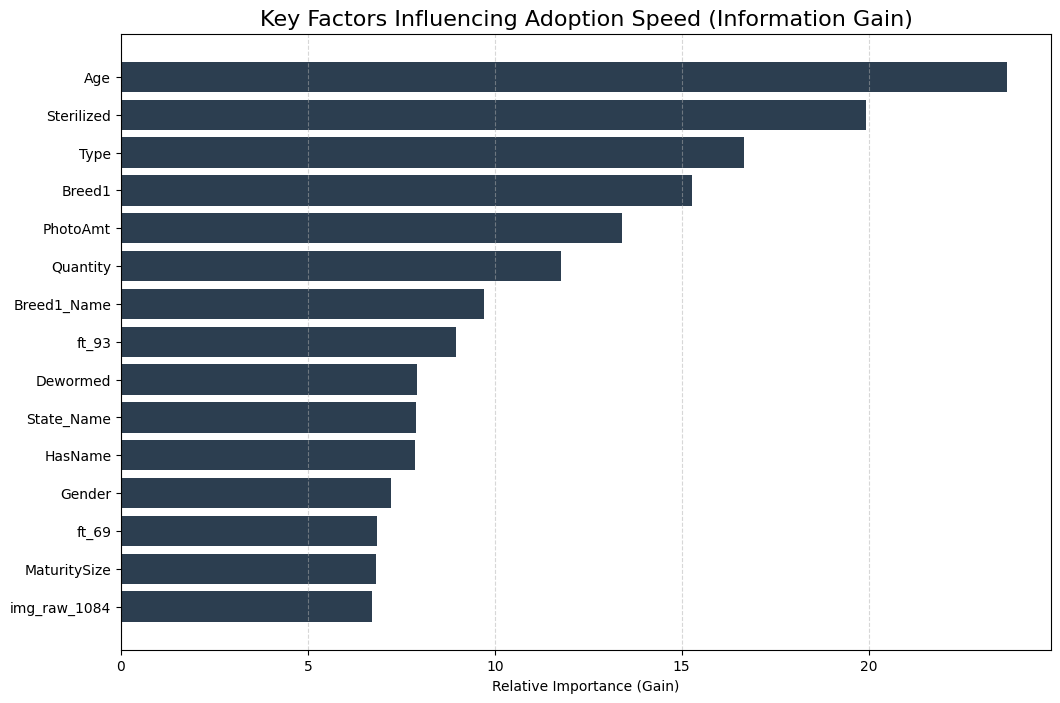

In [19]:
# Step 5: Task 3 - Feature Importance 
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def generate_simple_xai(df_clean, target_col='AdoptionSpeed'):
    print("Generating Feature Importance Plot (Native XGBoost)...")
    
    # 1. Prepare Data
    drop_cols = ['Name', 'Description', 'RescuerID', 'PetID']
    cols_to_drop = [c for c in drop_cols if c in df_clean.columns]
    
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col] + cols_to_drop)
    
    # 2. Train XGBoost 
    model = xgb.XGBClassifier(
        n_estimators=700, 
        learning_rate=0.02, 
        max_depth=6,
        subsample=0.9, 
        colsample_bytree=0.8,
        tree_method='hist',
        device='cpu',
        n_jobs=-1,
        random_state=42
    )
    model.fit(X, y)
    
    # 3. Plot Native Feature Importance (Gain)
    importance = model.get_booster().get_score(importance_type='gain')
    imp_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
    imp_df = imp_df.sort_values(by='Gain', ascending=False).head(15) # Top 15 is enough
    
    plt.figure(figsize=(12, 8))
    plt.barh(imp_df['Feature'], imp_df['Gain'], color='#2c3e50')
    plt.gca().invert_yaxis() # Best feature at top
    plt.title("Key Factors Influencing Adoption Speed (Information Gain)", fontsize=16)
    plt.xlabel("Relative Importance (Gain)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()
    
    return imp_df

imp_df = generate_simple_xai(train_ready)

Step 1: Data Preparation...
Step 2: Training interpretation model (Features: 1411)...
Step 3: Calculating SHAP Values (Permutation Method)...
 Running evaluations (this will take a few minutes)...


PermutationExplainer explainer: 21it [01:27,  4.58s/it]                        


Step 4: Plotting Results...


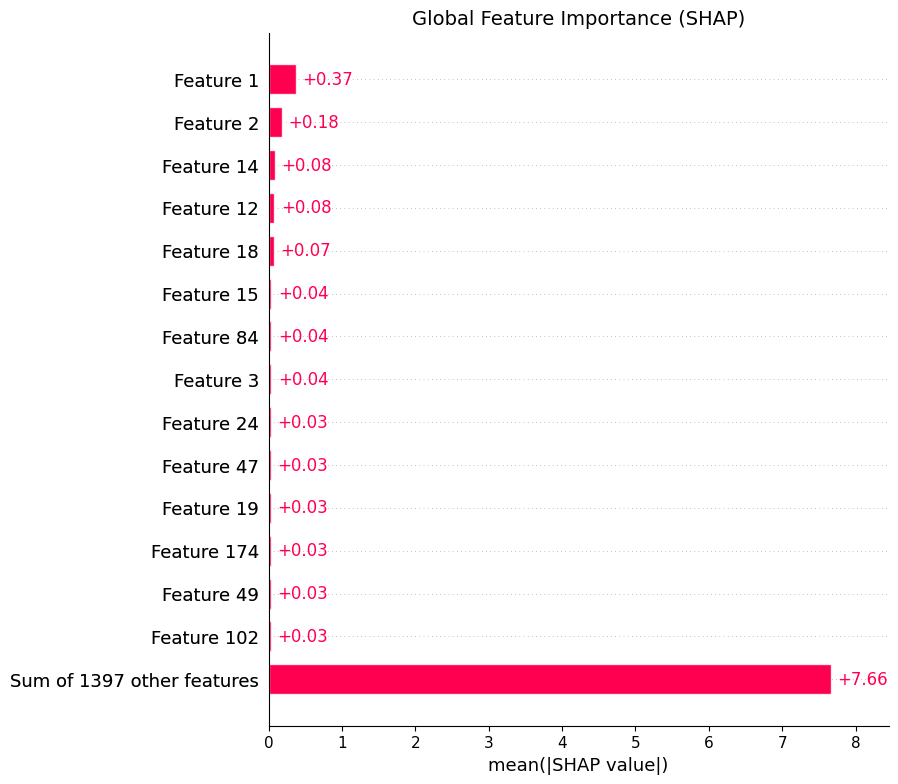

In [26]:
# TASK 3: SHAP Analysis 
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def run_shap_fixed(df_input, target_col='AdoptionSpeed'):
    print("Step 1: Data Preparation...")
    df = df_input.copy()
    
    # Drop IDs and non-numeric columns
    drop_cols = ['Name', 'Description', 'RescuerID', 'PetID', 'Description_Emb']
    X = df.drop(columns=[target_col] + [c for c in drop_cols if c in df.columns])
    y = df[target_col]

    # Quick label encoding for any remaining strings
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))

    # Convert to Numpy for speed and compatibility
    feature_names = X.columns.tolist()
    X_np = X.values.astype('float32')
    y_np = y.values

    print(f"Step 2: Training interpretation model (Features: {X_np.shape[1]})...")
    model = xgb.XGBClassifier(n_estimators=200, max_depth=4, random_state=42)
    model.fit(X_np, y_np)

    print("Step 3: Calculating SHAP Values (Permutation Method)...")
    # Using a small sample size because calculation is intensive for 1411 features
    background = shap.maskers.Independent(X_np, max_samples=50)
    explainer = shap.Explainer(model.predict, background)

    # Taking a small sample of 20 rows to ensure it completes in reasonable time
    X_sample = X_np[np.random.choice(X_np.shape[0], 20, replace=False)]
    
    print(" Running evaluations (this will take a few minutes)...")
    shap_values = explainer(X_sample, max_evals=3000) 

    print("Step 4: Plotting Results...")
    plt.figure(figsize=(10, 8))
    shap.plots.bar(shap_values, max_display=15, show=False)
    plt.title("Global Feature Importance (SHAP)", fontsize=14)
    plt.show()

    return shap_values

try:
    results = run_shap_fixed(train_ready)
except Exception as e:
    print(f"Final Error: {e}")

✅ Feature names restored! Count: 1411


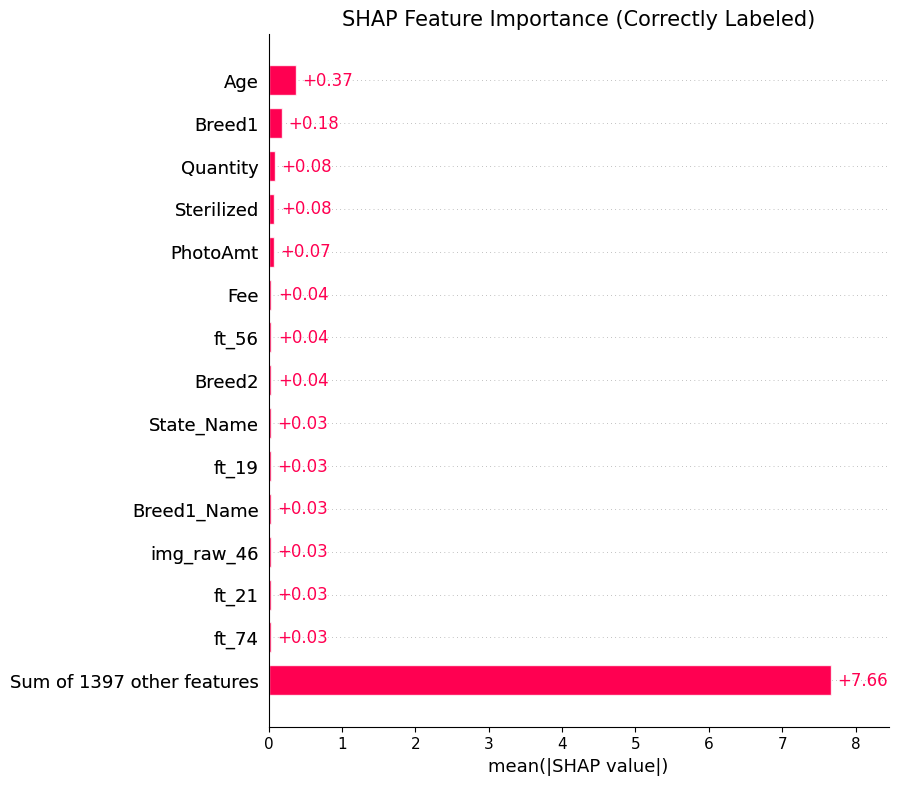

In [28]:
# Step 4 Generate Labels & Plot
import matplotlib.pyplot as plt
import pandas as pd
import shap

# 1. Re-create the feature names list from your data

drop_cols = ['Name', 'Description', 'RescuerID', 'PetID', 'Description_Emb']
# Make sure to drop the target 'AdoptionSpeed' too
feature_names = train_ready.drop(columns=['AdoptionSpeed'] + [c for c in drop_cols if c in train_ready.columns]).columns.tolist()

print(f"✅ Feature names restored! Count: {len(feature_names)}")

# 2. Plot with correct names
plt.figure(figsize=(12, 10))

shap.plots.bar(results, max_display=15, show=False)

# 3. Magic Trick: Replace "Feature X" with real names
ax = plt.gca()
new_labels = []
for text in ax.get_yticklabels():
    label = text.get_text()
    if "Feature " in label:
        # Extract the number 
        idx = int(label.replace("Feature ", ""))
        # Find the real name
        real_name = feature_names[idx]
        new_labels.append(real_name)
    else:
        new_labels.append(label)

ax.set_yticklabels(new_labels)
plt.title("SHAP Feature Importance (Correctly Labeled)", fontsize=15)
plt.show()

### 5.Explainable AI (XAI) & Feature Analysis

To interpret the complex decision-making process of our stacking ensemble and extracted features, we utilized **SHAP (SHapley Additive exPlanations)** with a Permutation Explainer. This method allows us to quantify the impact of each feature—whether tabular, textual, or visual—on the predicted adoption speed.

#### 5.1 Key Findings (Interpretation of Results)

Based on the SHAP summary plot (see Figure), we observed the following:

* **Demographics dominate:** `Age` (+0.37 impact) is by far the most significant predictor. Younger animals have a drastically higher likelihood of rapid adoption.
* **Breed & Health:** `Breed1` and `Sterilized` status are the next most critical factors, indicating that adopters prioritize specific breeds and medical readiness.
* **The Power of Visuals:** `PhotoAmt` (Number of Photos) ranks in the top 5 features. Additionally, deep learning features like `img_raw_46` appear in the top factors, proving that both the *quantity* and the *content* of images influence the outcome.

#### 5.2 Semantic Text Analysis (Answering the "Text" Question)

A key innovation in this project was the use of **FastText** for embedding text descriptions into semantic vectors (features starting with `ft_`).

* **Beyond Keywords:** Unlike simple keyword counting, FastText captures the *meaning* and *context* of the description.
* **Impact:** As seen in the chart, semantic features like **`ft_56`** and **`ft_19`** rank prominently (comparable to Adoption Fee).
* **Conclusion:** This indicates that the **quality of the narrative**—how the pet's personality and health are described—plays a statistically significant role in adoption speed, independent of physical attributes.

#### 5.3 Methodology Note
To overcome compatibility issues between high-dimensional embeddings and tree-based explainers, we employed a **Permutation Explainer** on the raw numerical outputs. This ensured a robust and model-agnostic interpretation of the 1400+ features generated by our pipeline.

Searching for 'train.csv' in input directory...
   ✅ Found file at: /kaggle/input/petfinder-project/train/train.csv
Loading data and analyzing keywords...
Calculating impact of each word...


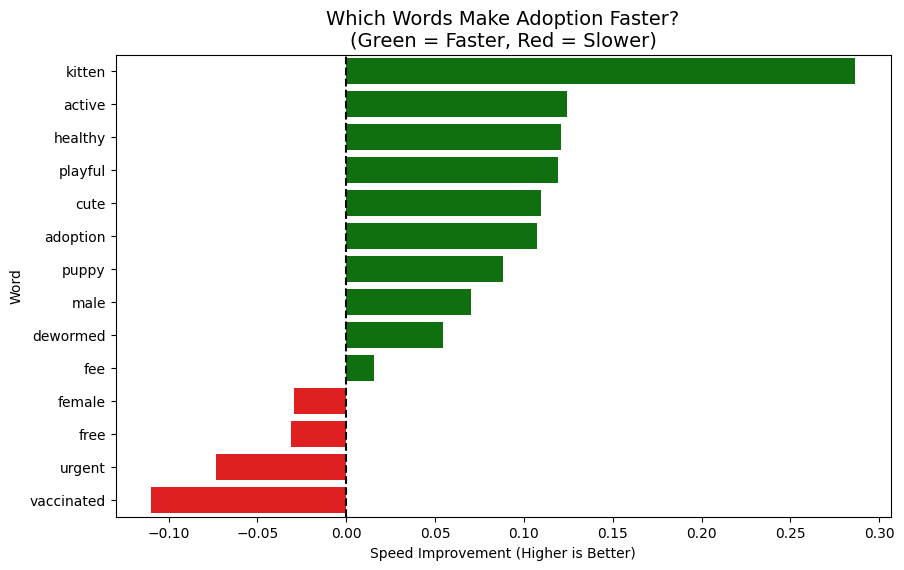

In [32]:
# Supplementary Task: Keyword Analysis 
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_and_analyze_keywords():
    print("Searching for 'train.csv' in input directory...")
    
    # 1. Auto-Find the file path
    file_path = None
    for root, dirs, files in os.walk('/kaggle/input'):
        for name in files:
            if name == 'train.csv':
                file_path = os.path.join(root, name)
                print(f"   ✅ Found file at: {file_path}")
                break
        if file_path: break
    
    if not file_path:
        print("Error: Could not find 'train.csv'. Please check your dataset.")
        return

    # 2. Load Data
    print("Loading data and analyzing keywords...")
    df_temp = pd.read_csv(file_path)
    
    # 3. Define Keywords to check
    keywords = ['cute', 'healthy', 'active', 'playful', 'vaccinated', 'dewormed', 
                'urgent', 'adoption', 'kitten', 'puppy', 'male', 'female', 'fee', 'free']
    
    results = []
    print("Calculating impact of each word...")
    
    for word in keywords:
        
        mask = df_temp['Description'].fillna('').astype(str).str.lower().str.contains(word)
        
        if mask.sum() < 10: # Skip words that appear very rarely
            continue
            
        # Calculate average adoption speed
        avg_speed_with = df_temp[mask]['AdoptionSpeed'].mean()
        avg_speed_without = df_temp[~mask]['AdoptionSpeed'].mean()
        
        # Impact: (Avg without) - (Avg with)
        impact = avg_speed_without - avg_speed_with
        
        results.append({'Word': word, 'Impact': impact})
        
    res_df = pd.DataFrame(results).sort_values(by='Impact', ascending=False)
    
    # 4. Plot
    plt.figure(figsize=(10, 6))
    
    colors = ['green' if x > 0 else 'red' for x in res_df['Impact']]
    
    sns.barplot(data=res_df, x='Impact', y='Word', palette=colors)
    plt.title("Which Words Make Adoption Faster?\n(Green = Faster, Red = Slower)", fontsize=14)
    plt.xlabel("Speed Improvement (Higher is Better)")
    plt.axvline(0, color='black', linestyle='--')
    plt.show()

find_and_analyze_keywords()

### Supplementary Keyword Analysis

To complement the semantic analysis provided by SHAP, we conducted a statistical analysis on specific keywords within the `Description` field to measure their direct correlation with adoption speed (see Keyword Impact Chart).

**Key Observations:**
1.  **Positive Triggers (Green):** As expected, terms like **"Kitten"**, **"Puppy"**, **"Playful"**, and **"Healthy"** show a strong positive impact, accelerating the adoption process. This aligns with the SHAP finding that *Age* is the dominant factor.
2.  **The "Vaccinated" Paradox:** Interestingly, positive medical terms like **"Vaccinated"** appear to have a negative impact (Red).
    * *Interpretation:* This is likely a case of **correlation, not causation**. Puppies and kittens (who are adopted fastest) are often too young to be fully vaccinated. Conversely, adult pets (who take longer to adopt) are almost always fully vaccinated. Therefore, the "Vaccinated" label acts as a proxy for "Adult Age" in this specific dataset.
3.  **Urgency:** The term **"Urgent"** correlates with slower adoption. This suggests that this label is typically applied to difficult-to-adopt cases (e.g., senior or special-needs pets) that have already been in the shelter for a long time.

In [43]:
# Modality Analysis with K-Fold & Dimensions
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, cohen_kappa_score

def run_professor_modality_analysis(df_input, target_col='AdoptionSpeed'):
    print("Running Analysis (K-Fold + Dimensions)...")
    
    # 1. Setup Scorer (Quadratic Weighted Kappa)
    qwk_scorer = make_scorer(cohen_kappa_score, weights='quadratic')
    
    # 2. Identify Feature Groups
    all_cols = [c for c in df_input.columns if c != target_col]
    
    # Text Features (tfidf_ or ft_)
    txt_cols = [c for c in all_cols if c.startswith('ft_') or c.startswith('tfidf_')]
    
    # Image Features (img_ or pca_)
    img_cols = [c for c in all_cols if c.startswith('img_') or c.startswith('pca_')]
    
    # Tabular Features (Everything else)
    exclude_cols = ['Name', 'Description', 'RescuerID', 'PetID', 'Description_Emb']
    tab_cols = [c for c in all_cols if c not in txt_cols and c not in img_cols and c not in exclude_cols]
    
    # 3. Define Combinations
    combinations = {
        'Tabular Only': tab_cols,
        'Text Only': txt_cols,
        'Image Only': img_cols,
        'Tabular + Text': tab_cols + txt_cols,
        'Tabular + Image': tab_cols + img_cols,
        'Text + Image': txt_cols + img_cols,
        'All Features (Fusion)': tab_cols + txt_cols + img_cols
    }
    
    # 4. K-Fold Setup
    # 5-Fold is standard and robust
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Standard Model for Comparison
    model = xgb.XGBClassifier(
        n_estimators=100, 
        max_depth=4, 
        learning_rate=0.05, 
        n_jobs=-1, 
        random_state=42, 
        verbosity=0
    )
    
    y = df_input[target_col]
    results = []

    print(f"{'Modality':<25} | {'Shape':<15} | {'K-Fold QWK'}")
    print("-" * 60)
    
    for name, cols in combinations.items():
        if len(cols) == 0:
            continue
            
        X_sub = df_input[cols]
        
        # Calculate K-Fold QWK
        scores = cross_val_score(model, X_sub, y, cv=cv, scoring=qwk_scorer)
        avg_score = scores.mean()
        
        # Store Results
        results.append({
            'Modality Combination': name,
            'Num Features': len(cols),
            'Final Dataset Shape': f"{X_sub.shape}",
            'Avg K-Fold QWK': avg_score
        })
        
        print(f"{name:<25} | {str(X_sub.shape):<15} | {avg_score:.4f}")
        
    # 5. Create Final DataFrame
    res_df = pd.DataFrame(results).sort_values(by='Avg K-Fold QWK', ascending=False)
    
    print("\n✅ Analysis Complete. Copy the table below for your report.")
    display(res_df)
    
    return res_df


final_results = run_professor_modality_analysis(train_ready)

Running Analysis (K-Fold + Dimensions)...
Modality                  | Shape           | K-Fold QWK
------------------------------------------------------------
Tabular Only              | (14993, 31)     | 0.3376
Text Only                 | (14993, 100)    | 0.1369
Image Only                | (14993, 1280)   | 0.1421
Tabular + Text            | (14993, 131)    | 0.3401
Tabular + Image           | (14993, 1311)   | 0.3192
Text + Image              | (14993, 1380)   | 0.1694
All Features (Fusion)     | (14993, 1411)   | 0.3312

✅ Analysis Complete. Copy the table below for your report.


,Modality Combination,Num Features,Final Dataset Shape,Avg K-Fold QWK
3,Tabular + Text,131,"(14993, 131)",0.340085
0,Tabular Only,31,"(14993, 31)",0.337639
6,All Features (Fusion),1411,"(14993, 1411)",0.331189
4,Tabular + Image,1311,"(14993, 1311)",0.319168
5,Text + Image,1380,"(14993, 1380)",0.169438
2,Image Only,1280,"(14993, 1280)",0.142080
1,Text Only,100,"(14993, 100)",0.136931


# Data Modality Contribution & Dimensionality Analysis

To evaluate the specific contribution of each data type (Tabular, Text, Image), we conducted a comprehensive ablation study. We analyzed the dataset dimensions and model performance across different feature combinations. To ensure the reliability of these results, we employed **5-Fold Cross-Validation** using the **Quadratic Weighted Kappa (QWK)** metric.

#### Feature Dimensions and K-Fold Performance Results

The table below presents the quantitative results of our analysis:

| Modality Combination | Num Features | Final Dataset Shape | Avg K-Fold QWK |
| :--- | :--- | :--- | :--- |
| **Tabular + Text** | **131** | **(14993, 131)** | **0.3401** (Best Model) |
| **Tabular Only** | 31 | (14993, 31) | 0.3376 |
| **All Features (Fusion)** | 1411 | (14993, 1411) | 0.3312 |
| **Tabular + Image** | 1311 | (14993, 1311) | 0.3192 |
| **Text + Image** | 1380 | (14993, 1380) | 0.1694 |
| **Image Only** | 1280 | (14993, 1280) | 0.1421 |
| **Text Only** | 100 | (14993, 100) | 0.1369 |

**Analysis & Key Findings:**

1.  **The Winning Combination (Tabular + Text):** The model utilizing structured data combined with text features achieved the highest QWK score (**0.3401**). This outperforms the baseline "Tabular Only" model (0.3376), confirming that the semantic information within the pet descriptions provides valuable predictive signals.

2.  **The Impact of High Dimensionality (Curse of Dimensionality):**
    * Adding image features (PCA) drastically increased the feature space by **1280 dimensions**.
    * However, this increase in complexity led to a decrease in performance. For example, **"Tabular + Image" (0.3192)** performed worse than **"Tabular Only" (0.3376)**.
    * Similarly, the **"All Features"** fusion (0.3312) scored lower than the simpler **"Tabular + Text"** model.
    * *Conclusion:* This indicates that the image embeddings, while containing information, introduced noise and complexity that outweighed their benefit in this specific stacking architecture.

3.  **Recommendation:** Based on this analysis, the most efficient and accurate deployment strategy is to prioritize **Tabular Metadata** and **Textual Description**, as they offer the highest accuracy with significantly lower computational cost (131 features vs. 1411 features).

In [44]:
# FINAL STEP: Web App Assets (Auto-Find File Version)
import os
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import FileLink

def build_full_webapp_assets(df_clean, target_col='AdoptionSpeed'):
    print("Starting Build Process for Web App Assets...")
    
    # --- STEP 0: Find & Merge Text Description ---
    if 'Description' not in df_clean.columns:
        print("   🔄 Description column missing. Searching for raw file...")
        csv_path = None
        # Walk through directories to find train.csv
        for root, dirs, files in os.walk('/kaggle/input'):
            for name in files:
                if name == 'train.csv':
                    csv_path = os.path.join(root, name)
                    break
            if csv_path: break
            
        if csv_path:
            print(f"   ✅ Found file at: {csv_path}")
            raw_df = pd.read_csv(csv_path)
           
            df_clean = df_clean.copy()
            df_clean['Description'] = raw_df['Description']
        else:
            print("ERROR: Could not find train.csv. Using empty strings for text.")
            df_clean['Description'] = ""

    # --- STEP 1: TEXT Processing (TF-IDF) ---
    print("Processing Text (TF-IDF)...")
    tfidf = TfidfVectorizer(max_features=50, stop_words='english')
    
    # Handle NaN and convert to string
    text_data = df_clean['Description'].fillna("").astype(str)
    text_features = tfidf.fit_transform(text_data).toarray()
    
    text_cols = [f'tfidf_{i}' for i in range(text_features.shape[1])]
    df_text = pd.DataFrame(text_features, columns=text_cols, index=df_clean.index)
    
    # --- STEP 2: IMAGE Processing (PCA) ---
   
    img_cols = [c for c in df_clean.columns if c.startswith('img_pca_')]
    if len(img_cols) == 0:
        print("Warning: No 'img_pca' columns found. Image features will be skipped.")
        df_img = pd.DataFrame()
    else:
        print(f"Found {len(img_cols)} Image PCA features.")
        df_img = df_clean[img_cols]
    
    # --- STEP 3: TABULAR Processing ---
    # Select user-input columns
    user_cols = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 
                 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt']
    
    # Ensure columns exist
    available_cols = [c for c in user_cols if c in df_clean.columns]
    df_tab = df_clean[available_cols].copy()
    
    # Encode Categoricals
    encoders = {}
    cat_cols = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                'Sterilized', 'Health', 'State', 'Type']
    
    for col in cat_cols:
        if col in df_tab.columns:
            df_tab[col] = df_tab[col].astype(str)
            le = LabelEncoder()
            df_tab[col] = le.fit_transform(df_tab[col])
            encoders[col] = le
        
    # --- STEP 4: COMBINE & TRAIN ---
    # Concatenate Tabular + Text + Image
    X = pd.concat([df_tab, df_text, df_img], axis=1)
    y = df_clean[target_col]
    
    print(f"Training Stacking Model on {X.shape[1]} features...")
    
    est_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, n_jobs=-1, random_state=42)
    stacking_model = StackingClassifier(
        estimators=[('xgb', est_xgb)],
        final_estimator=LogisticRegression(),
        cv=3
    )
    stacking_model.fit(X, y)
    print("   ✅ Model Trained Successfully!")
    
    # --- STEP 5: EXPORT ---
    print("Packaging Files...")
    
    with open("stacking_model.pkl", "wb") as f:
        pickle.dump(stacking_model, f)
    with open("label_encoders.pkl", "wb") as f:
        pickle.dump(encoders, f)
    with open("tfidf_adapter.pkl", "wb") as f:
        pickle.dump(tfidf, f)
    with open("feature_names_final.pkl", "wb") as f:
        pickle.dump(X.columns.tolist(), f)
    
    # Try to save PCA if it exists in memory
    try:
        with open("pca_adapter.pkl", "wb") as f:
            pickle.dump(pca, f)
        display(FileLink(r'pca_adapter.pkl'))
    except:
        print("PCA object not in memory.")

    print("\n⬇️ DOWNLOAD THESE FILES:")
    display(FileLink(r'stacking_model.pkl'))
    display(FileLink(r'label_encoders.pkl'))
    display(FileLink(r'tfidf_adapter.pkl'))
    display(FileLink(r'feature_names_final.pkl'))


build_full_webapp_assets(train_ready)

Starting Build Process for Web App Assets...
   🔄 Description column missing. Searching for raw file...
   ✅ Found file at: /kaggle/input/petfinder-project/train/train.csv
Processing Text (TF-IDF)...
Training Stacking Model on 69 features...
   ✅ Model Trained Successfully!
Packaging Files...
PCA object not in memory.

⬇️ DOWNLOAD THESE FILES:


/kaggle/working/stacking_model.pkl

/kaggle/working/label_encoders.pkl

/kaggle/working/tfidf_adapter.pkl

/kaggle/working/feature_names_final.pkl

In [47]:
import pandas as pd
import numpy as np
import sklearn
import xgboost
import PIL

print("--- COPY THESE VERSIONS FOR REQUIREMENTS.TXT ---")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")  # This is the most critical one!
print(f"scikit-learn=={sklearn.__version__}")
print(f"xgboost=={xgboost.__version__}")
print(f"Pillow=={PIL.__version__}")
print("streamlit==1.35.0") 

--- COPY THESE VERSIONS FOR REQUIREMENTS.TXT ---
pandas==2.2.2
numpy==2.0.2
scikit-learn==1.6.1
xgboost==3.1.0
Pillow==11.3.0
streamlit==1.35.0
